# Sample grouping
In this notebook we present the concept of **sample groups**. We use the
handwritten digits dataset to highlight some surprising results.

In [1]:
from sklearn.datasets import load_digits

digits = load_digits()
data, target = digits.data, digits.target

We create a model consisting of a logistic regression classifier with a
preprocessor to scale the data.

<div class="admonition note alert alert-info">
<p class="first admonition-title" style="font-weight: bold;">Note</p>
<p class="last">Here we use a <tt class="docutils literal">MinMaxScaler</tt> as we know that each pixel's gray-scale is
strictly bounded between 0 (white) and 16 (black). This makes <tt class="docutils literal">MinMaxScaler</tt>
more suited in this case than <tt class="docutils literal">StandardScaler</tt>, as some pixels consistently
have low variance (pixels at the borders might almost always be zero if most
digits are centered in the image). Then, using <tt class="docutils literal">StandardScaler</tt> can result in
a very high scaled value due to division by a small number.</p>
</div>

In [2]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

model = make_pipeline(MinMaxScaler(), LogisticRegression(max_iter=1_000))

The idea is to compare the estimated generalization performance using
different cross-validation techniques and see how such estimations are
impacted by underlying data structures. We first use a `KFold`
cross-validation without shuffling the data.

In [3]:
from sklearn.model_selection import cross_val_score, KFold

cv = KFold(shuffle=False)
test_score_no_shuffling = cross_val_score(model, data, target, cv=cv, n_jobs=2)
print(
    "The average accuracy is "
    f"{test_score_no_shuffling.mean():.3f} ± "
    f"{test_score_no_shuffling.std():.3f}"
)

The average accuracy is 0.931 ± 0.027


Now, let's repeat the experiment by shuffling the data within the
cross-validation.

In [4]:
cv = KFold(shuffle=True)
test_score_with_shuffling = cross_val_score(
    model, data, target, cv=cv, n_jobs=2
)
print(
    "The average accuracy is "
    f"{test_score_with_shuffling.mean():.3f} ± "
    f"{test_score_with_shuffling.std():.3f}"
)

The average accuracy is 0.966 ± 0.009


We observe that shuffling the data improves the mean accuracy. We can go a
little further and plot the distribution of the testing score. For such
purpose we concatenate the test scores.

In [5]:
import pandas as pd

all_scores = pd.DataFrame(
    [test_score_no_shuffling, test_score_with_shuffling],
    index=["KFold without shuffling", "KFold with shuffling"],
).T

Let's now plot the score distributions.

/home/karansinghthakor/.local/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


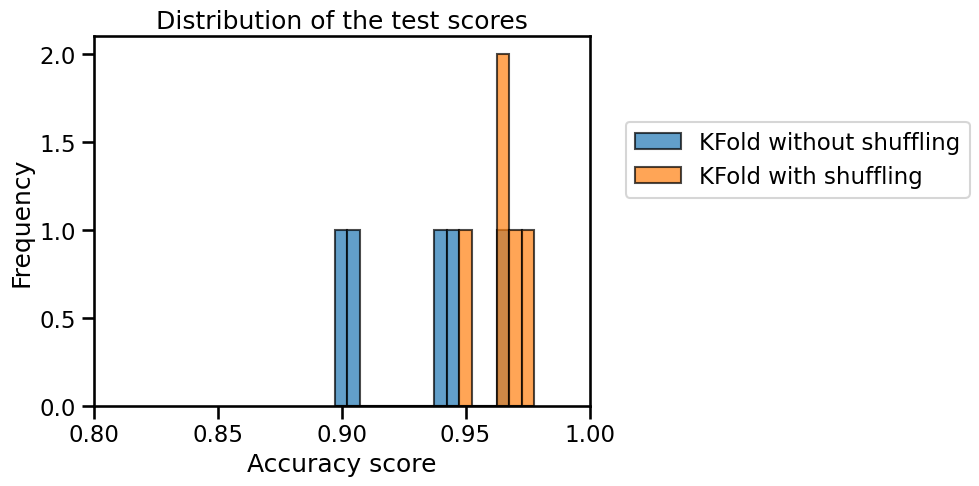

In [6]:
import matplotlib.pyplot as plt

all_scores.plot.hist(bins=16, edgecolor="black", alpha=0.7)
plt.xlim([0.8, 1.0])
plt.xlabel("Accuracy score")
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
_ = plt.title("Distribution of the test scores")

Shuffling the data results in a higher cross-validated test accuracy with less
variance compared to when the data is not shuffled. It means that some
specific fold leads to a low score in this case.

In [7]:
print(test_score_no_shuffling)

[0.94166667 0.89722222 0.94707521 0.96657382 0.90250696]


Thus, shuffling the data breaks the underlying structure and thus makes the
classification task easier to our model. To get a better understanding, we can
read the dataset description in more detail:

In [8]:
print(digits.DESCR)

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

:Number of Instances: 1797
:Number of Attributes: 64
:Attribute Information: 8x8 image of integer pixels in the range 0..16.
:Missing Attribute Values: None
:Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
:Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each block. This generates
an in

If we read carefully, `load_digits` loads a copy of the **test set** of the
UCI ML hand-written digits dataset, which consists of 1797 images by
**13 different writers**. Thus, each writer wrote several times the same
numbers. Let's suppose the dataset is ordered by writer. Subsequently,
not shuffling the data will keep all writer samples together either in the
training or the testing sets. Mixing the data will break this structure, and
therefore digits written by the same writer will be available in both the
training and testing sets.

Besides, a writer will usually tend to write digits in the same manner. Thus,
our model will learn to identify a writer's pattern for each digit instead of
recognizing the digit itself.

We can solve this problem by ensuring that the data associated with a writer
should either belong to the training or the testing set. Thus, we want to
group samples for each writer.

Indeed, we can recover the groups by looking at the target variable.

In [9]:
target[:200]

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1,
       2, 3, 4, 5, 6, 7, 8, 9, 0, 9, 5, 5, 6, 5, 0, 9, 8, 9, 8, 4, 1, 7,
       7, 3, 5, 1, 0, 0, 2, 2, 7, 8, 2, 0, 1, 2, 6, 3, 3, 7, 3, 3, 4, 6,
       6, 6, 4, 9, 1, 5, 0, 9, 5, 2, 8, 2, 0, 0, 1, 7, 6, 3, 2, 1, 7, 4,
       6, 3, 1, 3, 9, 1, 7, 6, 8, 4, 3, 1, 4, 0, 5, 3, 6, 9, 6, 1, 7, 5,
       4, 4, 7, 2, 8, 2, 2, 5, 7, 9, 5, 4, 8, 8, 4, 9, 0, 8, 9, 8, 0, 1,
       2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3,
       4, 5, 6, 7, 8, 9, 0, 9, 5, 5, 6, 5, 0, 9, 8, 9, 8, 4, 1, 7, 7, 3,
       5, 1, 0, 0, 2, 2, 7, 8, 2, 0, 1, 2, 6, 3, 3, 7, 3, 3, 4, 6, 6, 6,
       4, 9])


It might not be obvious at first, but there is a structure in the target:
there is a repetitive pattern that always starts by some series of ordered
digits from 0 to 9 followed by random digits at a certain point. If we look in
detail, we see that there are 14 such patterns, always with around 130 samples
each.

Even if it is not exactly corresponding to the 13 writers in the documentation
(maybe one writer wrote two series of digits), we can make the hypothesis that
each of these patterns corresponds to a different writer and thus a different
group.

In [10]:
from itertools import count
import numpy as np

# defines the lower and upper bounds of sample indices
# for each writer
writer_boundaries = [
    0,
    130,
    256,
    386,
    516,
    646,
    776,
    915,
    1029,
    1157,
    1287,
    1415,
    1545,
    1667,
    1797,
]
groups = np.zeros_like(target)
lower_bounds = writer_boundaries[:-1]
upper_bounds = writer_boundaries[1:]

for group_id, lb, up in zip(count(), lower_bounds, upper_bounds):
    groups[lb:up] = group_id

We can check the grouping by plotting the indices linked to writers' ids.

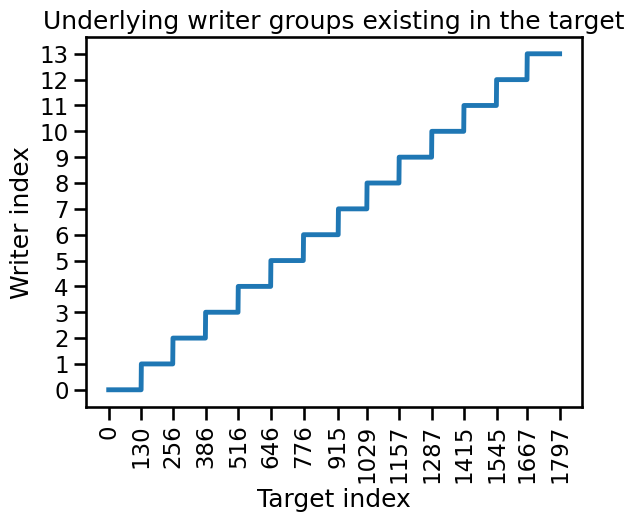

In [11]:
plt.plot(groups)
plt.yticks(np.unique(groups))
plt.xticks(writer_boundaries, rotation=90)
plt.xlabel("Target index")
plt.ylabel("Writer index")
_ = plt.title("Underlying writer groups existing in the target")

Once we group the digits by writer, we can incorporate this information into
the cross-validation process by using group-aware variations of the strategies
we have explored in this course, for example, the `GroupKFold` strategy.

In [12]:
from sklearn.model_selection import GroupKFold

cv = GroupKFold()
test_score = cross_val_score(
    model, data, target, groups=groups, cv=cv, n_jobs=2
)
print(
    f"The average accuracy is {test_score.mean():.3f} ± {test_score.std():.3f}"
)

The average accuracy is 0.921 ± 0.021


We see that this strategy leads to a lower generalization performance than the
other two techniques. However, this is the most reliable estimate if our goal
is to evaluate the capabilities of the model to generalize to new unseen
writers. In this sense, shuffling the dataset (or alternatively using the
writers' ids as a new feature) would lead the model to memorize the different
writer's particular handwriting.

In [13]:
all_scores = pd.DataFrame(
    [test_score_no_shuffling, test_score_with_shuffling, test_score],
    index=[
        "KFold without shuffling",
        "KFold with shuffling",
        "KFold with groups",
    ],
).T

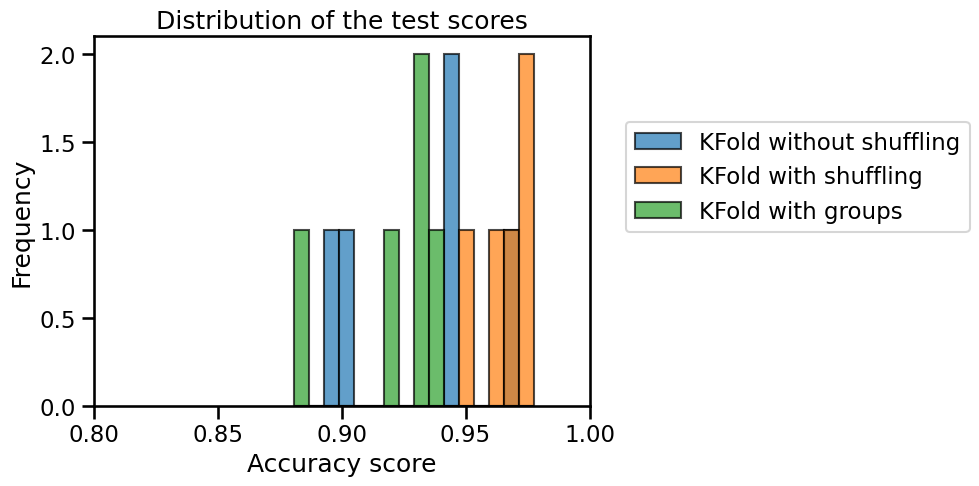

In [14]:
all_scores.plot.hist(bins=16, edgecolor="black", alpha=0.7)
plt.xlim([0.8, 1.0])
plt.xlabel("Accuracy score")
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
_ = plt.title("Distribution of the test scores")

In conclusion, accounting for any sample grouping patterns is crucial when
assessing a model’s ability to generalize to new groups. Without this
consideration, the results may appear overly optimistic compared to the actual
performance.

The interested reader can learn about other group-aware cross-validation
techniques in the [scikit-learn user
guide](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-iterators-for-grouped-data).